In [1]:
import matplotlib.pyplot as plt

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

### Notes First:

**How tall is A?**

- Suppose we choose 2 people from the population of adult males in the USA -> A and B. **If we see that A is taller than B then how tall is A?**

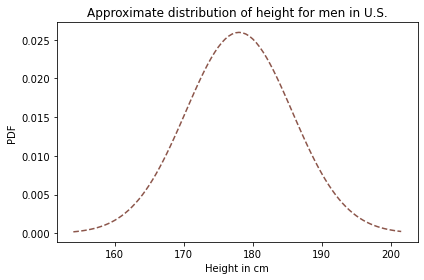

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from empiricaldist import Pmf

# Building a prior
mean = 178
qs = np.arange(mean-24, mean+24, 0.5)
std = 7.7
ps = norm(mean, std).pdf(qs) # build a prob density func

# Now we put in a Prob Mass Function and Normalize to get a
# discrete approximation of normal distribution
prior = Pmf(ps, qs)
prior.normalize()

# Plot
prior.plot(style='--', color='C5')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Approximate distribution of height for men in U.S.')


#### Prior:
- This represents what we believe about the heights of `A` and `B` before we take into account the data that `A` is taller

#### Joint Distribution: 
- Yields the pobability of every pair of heights
    - $P(A_{x} and P_{y})$
    - Build over all values of `x` and `y`
    
- Independence:
    - We can assume that random males in the US don't impact one another's height, knowing height of `A` tells me nothing of `B`
    - Therefore: $P(A_{x} and P_{y}) = P(A_{x}) P(B_{y})$


(96, 96)


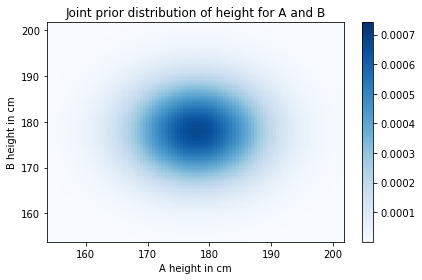

In [3]:
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

# Since X & Y are the same distribution we can pass in the prior
# build in last step
joint = make_joint(prior, prior)
print(joint.shape)

def plot_joint(joint, cmap='Blues'):
    """Plot a joint distribution with a color mesh."""
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint, 
                   cmap=cmap,
                   vmax=vmax,
                   shading='nearest')
    plt.colorbar()
    
    decorate(xlabel='A height in cm',
             ylabel='B height in cm')
    
plot_joint(joint)
decorate(title='Joint prior distribution of height for A and B')

### Likelihood:

We now update data where A is taller than B - this can be thought of as a filter of sorts as we are limiting down to scenarios where `X > Y`

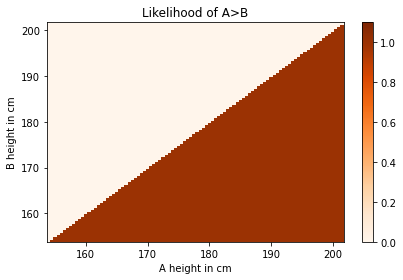

In [4]:
x = joint.columns
y = joint.index
X, Y = np.meshgrid(x, y) # this is just all heights 
A_taller = (X > Y) # filter for where X > y
a = np.where(A_taller, 1, 0)
likelihood = pd.DataFrame(a, index=x, columns=y) 
plot_joint(likelihood, cmap='Oranges')
decorate(title='Likelihood of A>B')

### Update:

The likelihood step effectively serves as a filter, wiping out instances where `B >= A`, and then renormalizing the data. 

I think we interpret the posterior as follows:

$P(A \& B | A > B) = \frac{P(A > B | A \& B) P(A \& B)}{P(A > B)}$

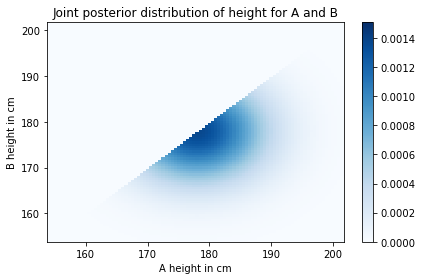

In [5]:
def normalize(joint):
    """Normalize a joint distribution."""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

# typical update:
posterior = joint * likelihood
normalize(posterior)

# plot
plot_joint(posterior)
decorate(title='Joint posterior distribution of height for A and B')

### Marginal Distributions:

- joint posterior tells us what we believe about heights of A and B given prior distributions and info that A is taller


In [6]:
# what is the prob that A is 180 cm tal?
posterior[180].sum() # sum of all posterior probs where x = 180

0.03017221271570807

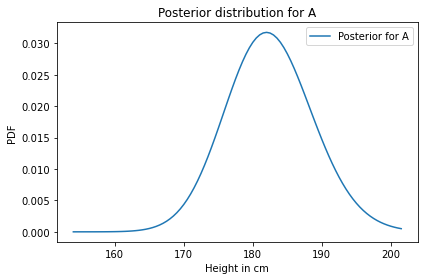

In [7]:
# this yields posterior distribution of height for A
# incorporating all heights 
column_sums = posterior.sum(axis=0)
marginal_A = Pmf(column_sums)
marginal_A.plot(label='Posterior for A')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Posterior distribution for A')

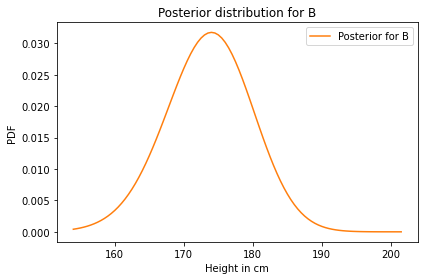

In [8]:
# and we can do the same for B, which is stored by row
row_sums = posterior.sum(axis=1)
marginal_B = Pmf(row_sums)
marginal_B.plot(label='Posterior for B', color='C1')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Posterior distribution for B')

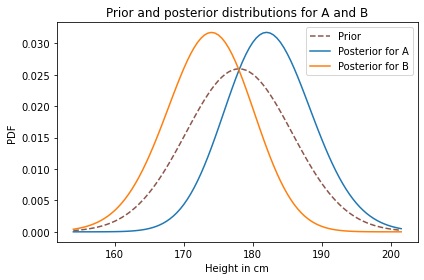

In [9]:
prior.plot(style='--', label='Prior', color='C5')
marginal_A.plot(label='Posterior for A')
marginal_B.plot(label='Posterior for B')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Prior and posterior distributions for A and B')

### Takeaway:

- Unsurprisingly, the marginal posterior for B is shifted below the prior - this makes sense since we know that `A > B`

### Conditional Posteriors: 

Assume we measure A and find he is 170 cm tall. What does that tell us about B?

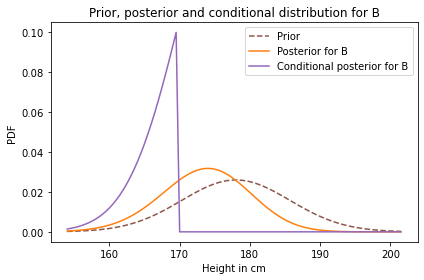

In [10]:
# grab the posterior
column_170 = posterior[170]

# we have a column of heights for B and likelihoods
# conditioned on A being 170
cond_B = Pmf(column_170)
cond_B.normalize()

prior.plot(style='--', label='Prior', color='C5')
marginal_B.plot(label='Posterior for B', color='C1')
cond_B.plot(label='Conditional posterior for B', 
            color='C4')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Prior, posterior and conditional distribution for B')

## Exercises:

### Exercise 1:

Based on the results of the previous example, compute the posterior conditional distribution for A given that B is 180 cm.

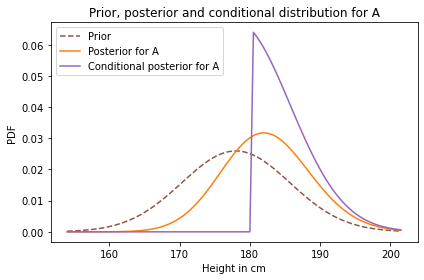

In [11]:
# grab the posterior, using loc for row
row_180 = posterior.loc[180]

# we have a column of heights for A and likelihoods
# conditioned on B being 180
cond_A = Pmf(row_180)
cond_A.normalize()

prior.plot(style='--', label='Prior', color='C5')
marginal_A.plot(label='Posterior for A', color='C1')
cond_A.plot(label='Conditional posterior for A', 
            color='C4')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Prior, posterior and conditional distribution for A')

### Exercise 2:

Suppose we have established that A is taller than B, but we don’t know how tall B is. Now we choose a random woman, C, and find that she is shorter than A by at least 15 cm. Compute posterior distributions for the heights of A and C.

The average height for women in the U.S. is 163 cm; the standard deviation is 7.3 cm.

#### Process:

- I assume I start in much the same manner as before, except this time I use my `marginal posterior of A` coupled with a `female prior` to build the joint distribution

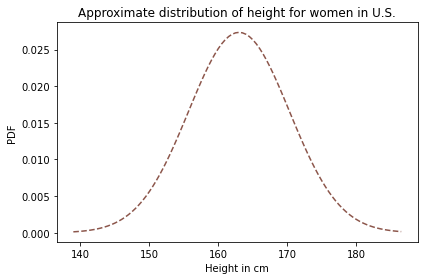

In [12]:
# build female prior 
mean = 163
qs = np.arange(mean-(8 * 3), mean+(8 * 3), 0.5) # range of vals, lazy to keeping range similar to men to get 96 vals

# stats
std = 7.3
ps = norm(mean, std).pdf(qs) 

# build pmf
prior_fem = Pmf(ps, qs)
prior_fem.normalize()

prior_fem.plot(style='--', color='C5')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Approximate distribution of height for women in U.S.');

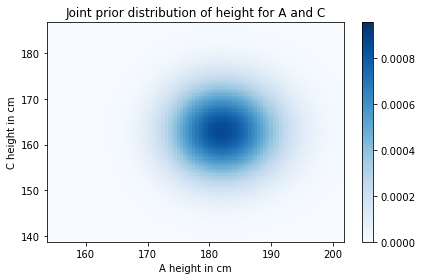

In [13]:
# build joint dist of posterior A with prior for females
joint_fem_prior = make_joint(marginal_A, prior_fem)

# visualize
def plot_joint(joint, cmap='Blues'):
    """Plot a joint distribution with a color mesh."""
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint, 
                   cmap=cmap,
                   vmax=vmax,
                   shading='nearest')
    plt.colorbar()
    
    decorate(xlabel='A height in cm',
             ylabel='C height in cm')
plot_joint(joint_fem_prior)
decorate(title='Joint prior distribution of height for A and C')

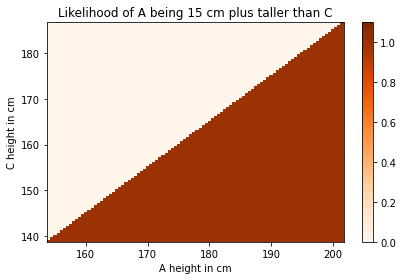

In [14]:
# And we build our likelihood
# except this time we know that C <= A - 15
x = joint_fem_prior.columns
y = joint_fem_prior.index

# Filter changes slightly
X, Y = np.meshgrid(x, y)

# A must be 15 or more taller
A_15_taller = (X - 15 >= Y)
a = np.where(A_15_taller, 1, 0) 

# And we get our likelihood
likelihood = pd.DataFrame(a, index=y, columns=x)

plot_joint(likelihood, cmap='Oranges')
decorate(title='Likelihood of A being 15 cm plus taller than C');

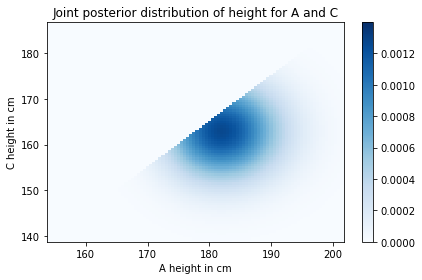

In [15]:
# update:
posterior_fem = joint_fem_prior * likelihood
normalize(posterior_fem)

# view plot
plot_joint(posterior_fem)
decorate(title='Joint posterior distribution of height for A and C')

Prior mean: 162.997
Posterior of C (after update): 160.122
Posterior of A (before update): 182.387
Posterior of A (after update): 184.497


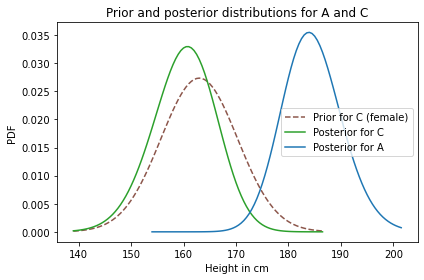

In [16]:
def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

# And just like before we can add over the marginals:
marginal_AC = marginal(posterior_fem, axis=0)
marginal_C = marginal(posterior_fem, axis=1)

# plot
prior_fem.plot(style='--', label='Prior for C (female)', color='C5')
marginal_C.plot(label='Posterior for C', color='C2')
marginal_AC.plot(label='Posterior for A', color='C0')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Prior and posterior distributions for A and C');

print(f"Prior mean: {prior_fem.mean():.3f}")
print(f"Posterior of C (after update): {marginal_C.mean():.3f}")
print(f"Posterior of A (before update): {marginal_A.mean():.3f}")
print(f"Posterior of A (after update): {marginal_AC.mean():.3f}")

#### Discussion Point:

- Given the constraint of A - 15 >= C it makes sense that the marginal posterior of C will shift to the left -> majority of higher heights are removed due to not meeting criteria.

- Nothing much else to say here, but glad to see the author took the easy route for establishing the initial `qs` vector

### Exercise 3:

 The Elo rating system is a way to quantify the skill level of players for games like chess.

It is based on a model of the relationship between the ratings of players and the outcome of a game. Specifically, if  is the rating of player A and  is the rating of player B, the probability that A beats B is given by the logistic function

$P(A beats B) = \frac{1}{1 + 10-^\frac{{R_{B} - R_{A}}}{400}}$

The parameters 10 and 400 are arbitrary choices that determine the range of the ratings. In chess, the range is from 100 to 2800.

Notice that the probability of winning depends only on the difference in rankings. As an example, if $R_{A}$ exceeds $R_{B}$  by 100 points, the probability that A wins is

In [17]:
1 / (1 + 10 ** (-100 / 400))

0.6400649998028851

In [18]:
# how about if equal?
1 / (1 + 10 ** (0 / 400))

0.5

Suppose A has a current rating of 1600, but we are not sure it is accurate. We could describe their true rating with a normal distribution with mean 1600 and standard deviation 100, to indicate our uncertainty.

And suppose B has a current rating of 1800, with the same level of uncertainty.

Then A and B play and A wins. How should we update their ratings?

To answer this question:

- Construct prior distributions for A and B.

- Use them to construct a joint distribution, assuming that the prior distributions are independent.

- Use the logistic function above to compute the likelihood of the outcome under each joint hypothesis.

- Use the joint prior and likelihood to compute the joint posterior.

- Extract and plot the marginal posteriors for A and B.

- Compute the posterior means for A and B. How much should their ratings change based on this outcome?

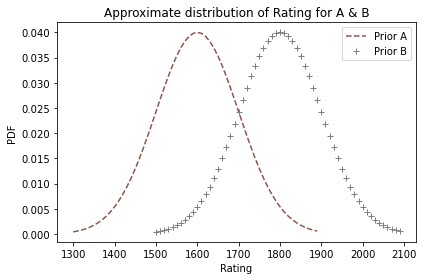

In [19]:
# Here's a prior distribution for A
mean = 1600
qs = np.arange(mean-300, mean+300, 10)
std = 100
ps = norm(mean, std).pdf(qs)
prior_a = Pmf(ps, qs)
prior_a.normalize()

# B
mean = 1800
qs = np.arange(mean-300, mean+300, 10)
std = 100
ps = norm(mean, std).pdf(qs)
prior_b = Pmf(ps, qs)
prior_b.normalize()

prior_a.plot(style='--', label = 'Prior A', color='C5')
prior_b.plot(style='+', label = 'Prior B', color='C7')

decorate(xlabel='Rating',
         ylabel='PDF',
         title='Approximate distribution of Rating for A & B');

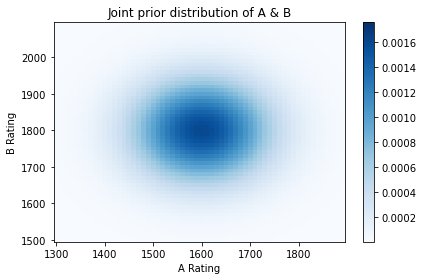

In [20]:
# build joint distribution
assert(prior_a.shape == prior_b.shape)

# build joint dist of posterior A with prior for females
joint_prior = make_joint(prior_a, prior_b)

# visualize
def plot_joint(joint, cmap='Blues'):
    """Plot a joint distribution with a color mesh."""
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint, 
                   cmap=cmap,
                   vmax=vmax,
                   shading='nearest')
    plt.colorbar()
    
    decorate(xlabel='A Rating',
             ylabel='B Rating')
plot_joint(joint_prior)
decorate(title='Joint prior distribution of A & B')

In [21]:
joint_prior.columns

Int64Index([1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400,
            1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510,
            1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620,
            1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730,
            1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840,
            1850, 1860, 1870, 1880, 1890],
           dtype='int64')

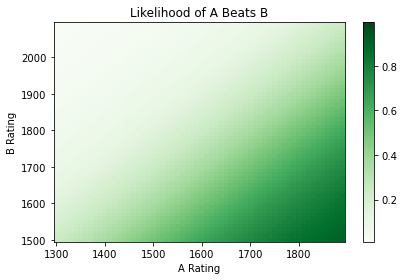

In [22]:
# Compute likelihood function under each joint hyp
a = joint_prior.columns
b = joint_prior.index
A, B = np.meshgrid(a, b)

# pass into logistic function shared
# solving as B - A since a (+) means A > B and will yield a higher likelihood
diff = B - A
a_beats_b = 1 / (1 + 10**(diff/400))
likelihood_AB = pd.DataFrame(a_beats_b, index=b, columns=a)

plot_joint(likelihood_AB, cmap='Greens')
decorate(xlabel = 'A Rating', ylabel='B Rating',
         title='Likelihood of A Beats B')

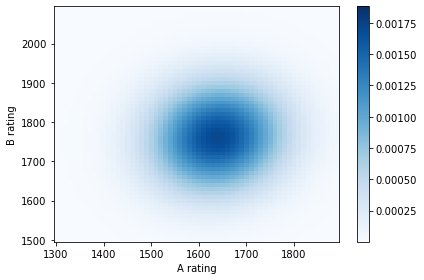

In [23]:
# Building the posterior
posterior_AB = joint_prior * likelihood_AB
normalize(posterior_AB)

# plot it out
plot_joint(posterior_AB)
decorate(xlabel = 'A rating', ylabel='B rating')

Prior mean: 1599.867
Posterior of A (after update): 1636.648


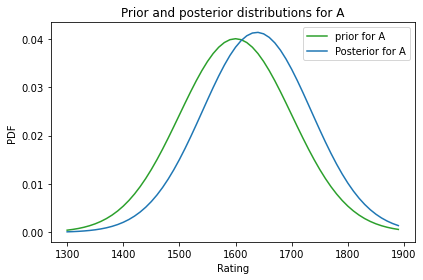

In [24]:
# Extract and plot the marginal posteriors for A and B.
# And just like before we can add over the marginals:
marginal_A = marginal(posterior_AB, axis=0)
marginal_B = marginal(posterior_AB, axis=1)

# plot
prior_a.plot(label='prior for A', color='C2')
marginal_A.plot(label='Posterior for A', color='C0')

decorate(xlabel='Rating',
         ylabel='PDF',
         title='Prior and posterior distributions for A');

print(f"Prior mean: {prior_a.mean():.3f}")
print(f"Posterior of A (after update): {marginal_A.mean():.3f}")

Prior mean: 1799.867
Posterior of B (after update): 1763.020


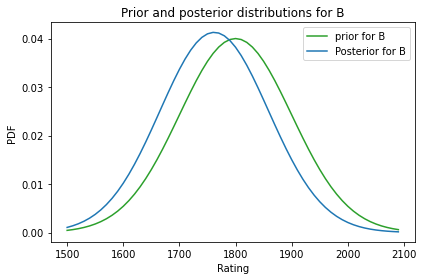

In [25]:
# plot B
prior_b.plot(label='prior for B', color='C2')
marginal_B.plot(label='Posterior for B', color='C0')

decorate(xlabel='Rating',
         ylabel='PDF',
         title='Prior and posterior distributions for B');

print(f"Prior mean: {prior_b.mean():.3f}")
print(f"Posterior of B (after update): {marginal_B.mean():.3f}")

In [26]:
# Compute the posterior means for A and B. How much should their ratings change based on this outcome?

### Interpretation:
    
What we did? 
- It is important to keep in mind that a stance was taken on the winner of this game, in my case I chose to have `A beat B`
- We looked at the our best guess of where `A` and `B` were based on information
    - We built a joint distribution with this information
- We then found the likelihood of `A` winning over `B` across all combinations of scores (this is where `B-A` factors in with the `diff` and `logistic function`)
    - This told us how likely it was to see various data points assuming A wins (Note: We could have assumed B won, which is what was run below).
- Joint posterior:
    - We look at each combination of `A v B` and multiply by the likelihood of `A beating B`
- Since `A` has a distribution shifted further to the left than `B` we would expect to see `marginal posterior of A` shift to the right given the assumption of A winning.
    - A higher score for `A` is more likely in posterior than prior since we assume A won, meaning our likelihood function is going to shift our distribution to the right as higher scores will have higher probabilities relative to lower scores. The reverse is true if B is assumed to win. 

What if B won?
- We should be able to see the opposite by taking `A - B` in likelihood:
    - We do see the shift, albeit not as extreme of a shift. This is because `B` already has a positively shifted distribution for prior relative to `A`, so there is not as much deviating information gained from the likelihood as in the prior example.

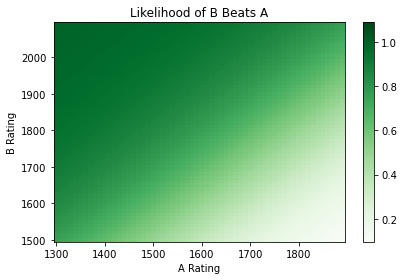

In [27]:
# Compute likelihood function reverse
diff = A - B
b_beats_a = 1 / (1 + 10**(diff/400))
likelihood_BA = pd.DataFrame(b_beats_a, index=b, columns=a)

plot_joint(likelihood_BA, cmap='Greens')
decorate(xlabel = 'A Rating', ylabel='B Rating',
         title='Likelihood of B Beats A')

Prior mean: 1599.867
Posterior of A (after update): 1586.534


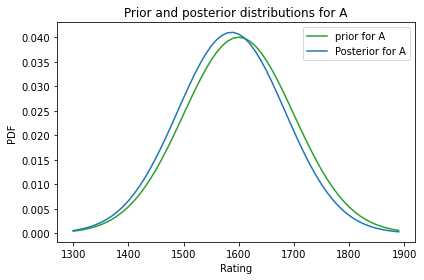

In [28]:
# Building the posterior
posterior_BA = joint_prior * likelihood_BA
normalize(posterior_BA)

# Extract and plot the marginal posteriors for A and B.
# And just like before we can add over the marginals:
marginal_A = marginal(posterior_BA, axis=0)
marginal_B = marginal(posterior_BA, axis=1)

# plot
prior_a.plot(label='prior for A', color='C2')
marginal_A.plot(label='Posterior for A', color='C0')

decorate(xlabel='Rating',
         ylabel='PDF',
         title='Prior and posterior distributions for A');

print(f"Prior mean: {prior_a.mean():.3f}")
print(f"Posterior of A (after update): {marginal_A.mean():.3f}")

Prior mean: 1799.867
Posterior of B (after update): 1813.223


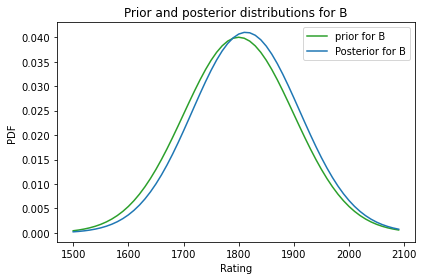

In [29]:
# plot B
prior_b.plot(label='prior for B', color='C2')
marginal_B.plot(label='Posterior for B', color='C0')

decorate(xlabel='Rating',
         ylabel='PDF',
         title='Prior and posterior distributions for B');

print(f"Prior mean: {prior_b.mean():.3f}")
print(f"Posterior of B (after update): {marginal_B.mean():.3f}")